## Imports & Config

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import librosa
import kagglehub

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

import config

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

C:\Users\shavi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Download RAVDESS Dataset

In [2]:
dataset_path = kagglehub.dataset_download(
    "uwrfkaggler/ravdess-emotional-speech-audio"
)
print("Dataset path:", dataset_path)

Dataset path: C:\Users\shavi\.cache\kagglehub\datasets\uwrfkaggler\ravdess-emotional-speech-audio\versions\1


## Emotion Mapping

In [3]:
EMOTION_MAP = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

EMOTION_TO_IDX = {v: i for i, v in enumerate(EMOTION_MAP.values())}
IDX_TO_EMOTION = {i: v for v, i in EMOTION_TO_IDX.items()}
NUM_EMOTIONS = len(EMOTION_TO_IDX)

print("Number of emotions:", NUM_EMOTIONS)

Number of emotions: 8


## Collect Audio Files

In [4]:
wav_files = []
for root, _, files in os.walk(dataset_path):
    for f in files:
        if f.endswith(".wav"):
            wav_files.append(os.path.join(root, f))

print("Total audio files:", len(wav_files))

Total audio files: 2880


## Feature Extraction 

In [5]:
def extract_log_mel(file_path):
    y, _ = librosa.load(file_path, sr=config.SAMPLE_RATE)

    mel = librosa.feature.melspectrogram(
        y=y,
        sr=config.SAMPLE_RATE,
        n_fft=config.N_FFT,
        hop_length=config.HOP_LENGTH,
        n_mels=config.N_MELS
    )

    log_mel = librosa.power_to_db(mel)

    if log_mel.shape[1] < config.MAX_FRAMES:
        pad = config.MAX_FRAMES - log_mel.shape[1]
        log_mel = np.pad(log_mel, ((0,0),(0,pad)))
    else:
        log_mel = log_mel[:, :config.MAX_FRAMES]

    return log_mel


## PyTorch Dataset

In [6]:
class RavdessDataset(Dataset):
    def __init__(self, files):
        self.files = files

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = self.files[idx]
        emotion_id = os.path.basename(file_path).split("-")[2]
        emotion = EMOTION_MAP[emotion_id]
        label = EMOTION_TO_IDX[emotion]

        features = extract_log_mel(file_path)
        features = torch.tensor(features, dtype=torch.float32).unsqueeze(0)
        label = torch.tensor(label, dtype=torch.long)

        return features, label

## Train / Validation Split

In [7]:
train_files, val_files = train_test_split(
    wav_files, test_size=0.2, random_state=42, shuffle=True
)

train_loader = DataLoader(
    RavdessDataset(train_files), batch_size=32, shuffle=True
)
val_loader = DataLoader(
    RavdessDataset(val_files), batch_size=32, shuffle=False
)

## Model

In [8]:
class CNNGRU(nn.Module):
    def __init__(self, num_emotions):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.gru = nn.GRU(64 * 16, 128, batch_first=True)
        self.fc = nn.Linear(128, num_emotions)

    def forward(self, x):
        x = self.cnn(x)
        x = x.permute(0, 3, 1, 2)
        x = x.reshape(x.size(0), x.size(1), -1)
        _, h = self.gru(x)
        return self.fc(h.squeeze(0))

## Train / Validation Logic

In [9]:
model = CNNGRU(NUM_EMOTIONS).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train_epoch(loader):
    model.train()
    loss_sum, correct, total = 0, 0, 0

    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)

    return loss_sum / len(loader), correct / total


@torch.no_grad()
def eval_epoch(loader):
    model.eval()
    loss_sum, correct, total = 0, 0, 0
    preds, labels = [], []

    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = criterion(out, y)

        loss_sum += loss.item()
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)

        preds.extend(out.argmax(1).cpu().numpy())
        labels.extend(y.cpu().numpy())

    return loss_sum / len(loader), correct / total, labels, preds

## Training Loop

In [10]:
EPOCHS = 25

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(EPOCHS):
    tr_loss, tr_acc = train_epoch(train_loader)
    val_loss, val_acc, _, _ = eval_epoch(val_loader)

    train_losses.append(tr_loss)
    val_losses.append(val_loss)
    train_accs.append(tr_acc)
    val_accs.append(val_acc)

    print(
        f"Epoch {epoch+1}/{EPOCHS} | "
        f"Train Acc: {tr_acc:.3f} | Val Acc: {val_acc:.3f}"
    )

Epoch 1/25 | Train Acc: 0.265 | Val Acc: 0.302
Epoch 2/25 | Train Acc: 0.311 | Val Acc: 0.306
Epoch 3/25 | Train Acc: 0.330 | Val Acc: 0.312
Epoch 4/25 | Train Acc: 0.362 | Val Acc: 0.382
Epoch 5/25 | Train Acc: 0.403 | Val Acc: 0.358
Epoch 6/25 | Train Acc: 0.462 | Val Acc: 0.422
Epoch 7/25 | Train Acc: 0.523 | Val Acc: 0.453
Epoch 8/25 | Train Acc: 0.602 | Val Acc: 0.488
Epoch 9/25 | Train Acc: 0.642 | Val Acc: 0.507
Epoch 10/25 | Train Acc: 0.726 | Val Acc: 0.571
Epoch 11/25 | Train Acc: 0.796 | Val Acc: 0.677
Epoch 12/25 | Train Acc: 0.826 | Val Acc: 0.655
Epoch 13/25 | Train Acc: 0.862 | Val Acc: 0.731
Epoch 14/25 | Train Acc: 0.897 | Val Acc: 0.720
Epoch 15/25 | Train Acc: 0.919 | Val Acc: 0.740
Epoch 16/25 | Train Acc: 0.938 | Val Acc: 0.788
Epoch 17/25 | Train Acc: 0.941 | Val Acc: 0.783
Epoch 18/25 | Train Acc: 0.950 | Val Acc: 0.771
Epoch 19/25 | Train Acc: 0.954 | Val Acc: 0.804
Epoch 20/25 | Train Acc: 0.966 | Val Acc: 0.809
Epoch 21/25 | Train Acc: 0.962 | Val Acc: 0.811
E

## Training Curves

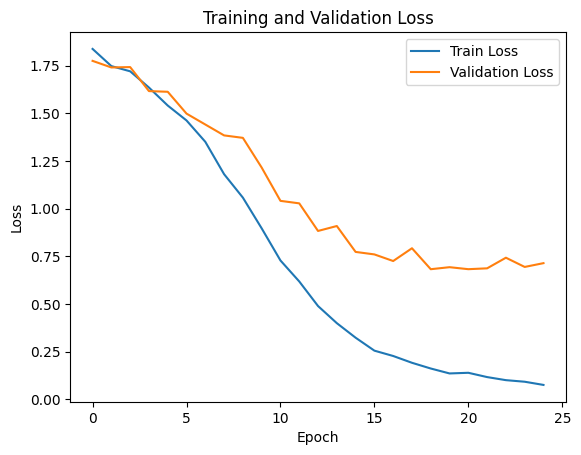

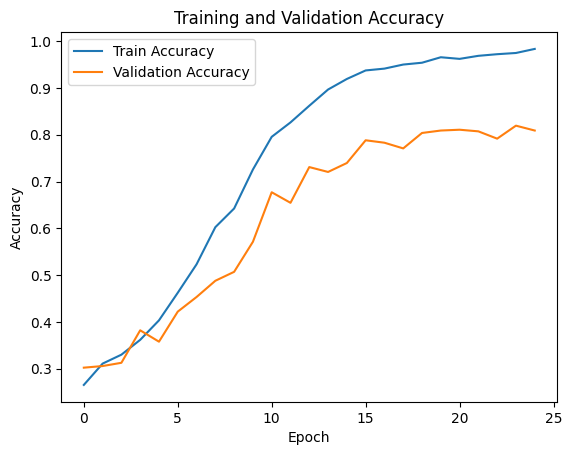

In [11]:
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.show()

plt.figure()
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.show()

## Confusion Matrix & Classification Report

              precision    recall  f1-score   support

     neutral       0.93      0.67      0.78        42
        calm       0.79      0.88      0.84        69
       happy       0.78      0.83      0.80        82
         sad       0.76      0.82      0.79        61
       angry       0.88      0.77      0.82        79
     fearful       0.85      0.85      0.85        80
     disgust       0.79      0.75      0.77        84
   surprised       0.77      0.85      0.81        79

    accuracy                           0.81       576
   macro avg       0.82      0.80      0.81       576
weighted avg       0.81      0.81      0.81       576



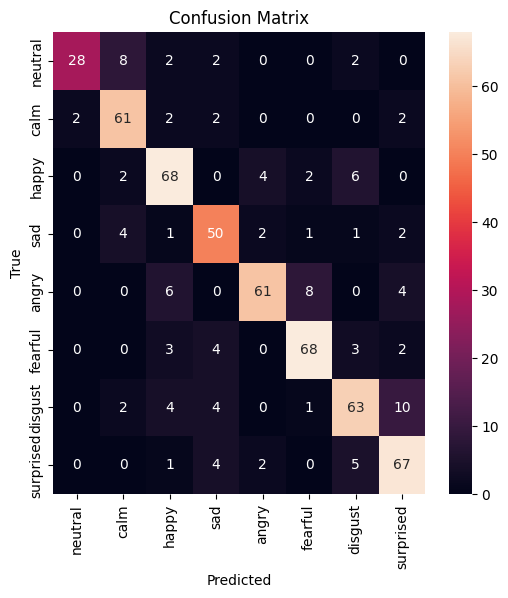

In [12]:
_, _, y_true, y_pred = eval_epoch(val_loader)

print(classification_report(
    y_true, y_pred, target_names=IDX_TO_EMOTION.values()
))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=IDX_TO_EMOTION.values(),
    yticklabels=IDX_TO_EMOTION.values()
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

## Saving Model

In [13]:
torch.save(model.state_dict(), config.MODEL_PATH)
print("Model saved to:", config.MODEL_PATH)

Model saved to: cnn_gru_ravdess.pth
